# Simple Classifiers - Generative AI Detection CLEF 2025

In this notebook we try to use some hand-crafted features to detect AI-generated text. We will look at the following features:

- Average sentence length  
- Average document length
- Average world length
- Lexical diversity (type-token ratio TTR)
- Stopword ratio
- Punctuation density
- Use of rare words (IDF)

Afterwards, we use these indicators to train a simple statistical model, such as a Random Forest.

In [16]:
from steely import DATA_TASK_2_DIR

import math
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')

train_df = pl.read_ndjson(DATA_TASK_2_DIR / "train.jsonl")
val_df = pl.read_ndjson(DATA_TASK_2_DIR / "dev.jsonl")
labels = {
    0: "fully human-written",
    1: "human-written, then machine-polished",
    2: "machine-written, then machine-humanized",
    3: "human-initiated, then machine-continued",
    4: "deeply-mixed text (human + machine parts)",
    5: "machine-written, then human-edited"
}
colors = ["lightgreen", "salmon", "lightblue", "orange", "purple", "black"]

len(train_df), len(val_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(288918, 72661)

## Document Length

In [ ]:
def classify_by_avg_doc_length(dataframe, labels_mapping, cutoff=math.inf):
    doc_lengths = [(min(len(doc[0]), cutoff), labels_mapping[doc[2]]) for doc in dataframe.iter_rows()]  # -> (len, label)
    lengths, labels_list = zip(*doc_lengths)
        
    plt.figure(figsize=(10, 6))
    for i in range(len(labels_mapping)):
        plt.hist([lengths[j] for j in range(len(lengths)) if labels_list[j] == labels_mapping[i]], 
                 bins=200, alpha=math.pow(0.8, i), label=labels_mapping[i], color=colors[i], density=True)
    #plt.xscale('log')  # Set x-axis to log scale
    plt.title(f'Document Length')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

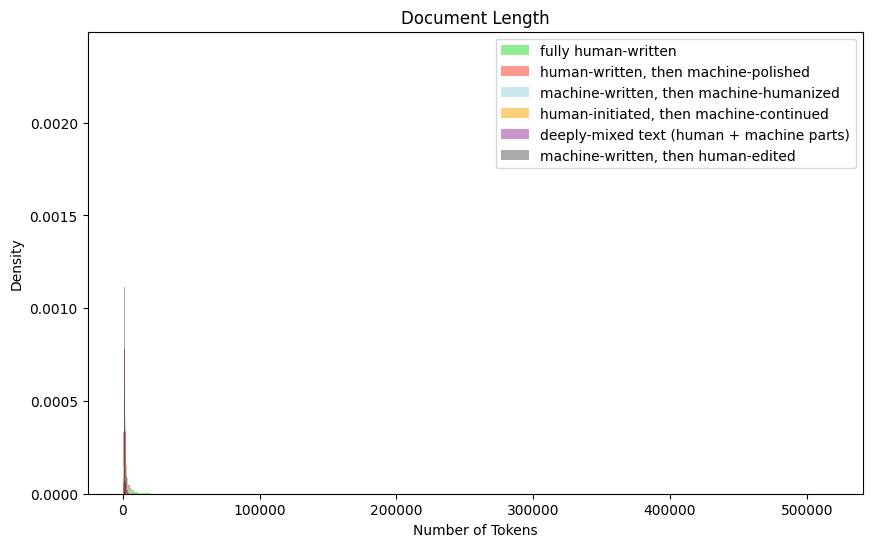

In [ ]:
classify_by_avg_doc_length(train_df, labels)

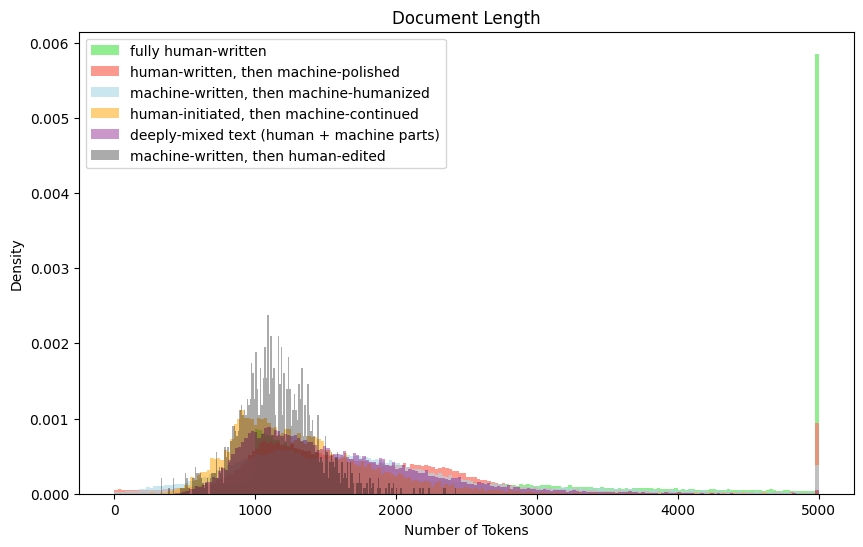

In [38]:
classify_by_avg_doc_length(train_df, labels, cutoff=5000)

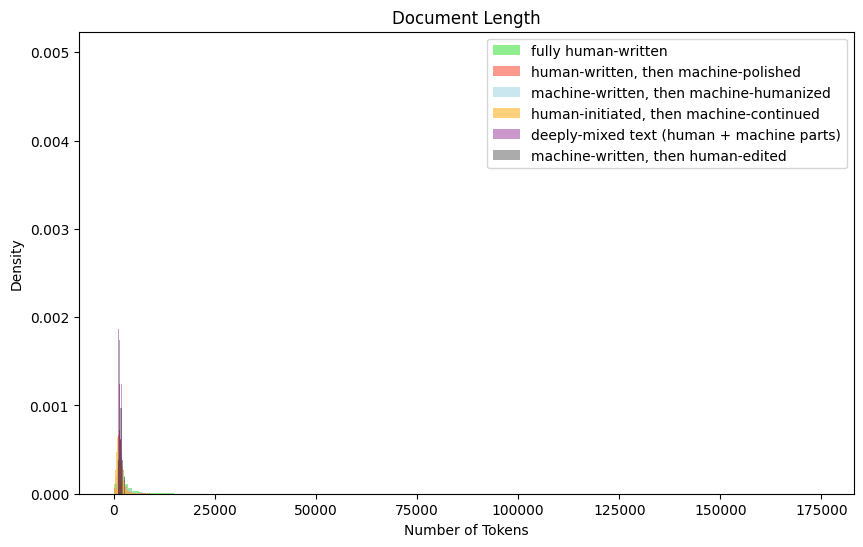

In [ ]:
classify_by_avg_doc_length(val_df, labels)

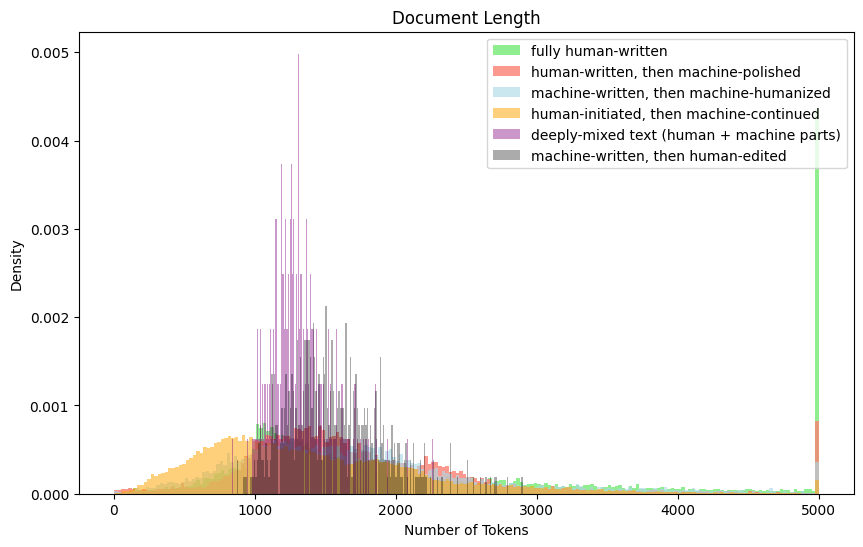

In [40]:
classify_by_avg_doc_length(val_df, labels, cutoff=5000)

## Average Sentence Length

In [ ]:
def classify_by_avg_sentence_length(dataframe, labels_mapping, cutoff=math.inf):
    avg_sentence_lengths = []
    for doc in dataframe.iter_rows():
        sentences = doc[0].split('.')
        avg_length = sum(len(sentence.split()) for sentence in sentences if sentence.strip()) / len(sentences)
        avg_sentence_lengths.append((min(avg_length, cutoff), labels_mapping[doc[2]]))  # -> (avg_length, label)
    lengths, labels_list = zip(*avg_sentence_lengths)

    plt.figure(figsize=(10, 6))
    for i in range(len(labels_mapping)):
        plt.hist([lengths[j] for j in range(len(lengths)) if labels_list[j] == labels_mapping[i]], 
                 bins=50, alpha=math.pow(0.8, i), label=labels_mapping[i], color=colors[i], density=True)
    plt.title(f'Average Sentence Length')
    plt.xlabel('Number of Tokens per Sentence')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

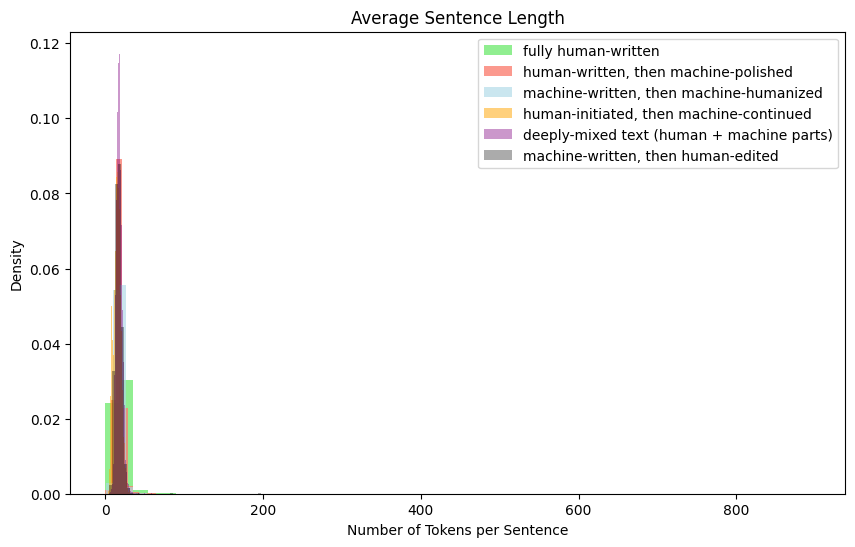

In [ ]:
classify_by_avg_sentence_length(train_df, labels)

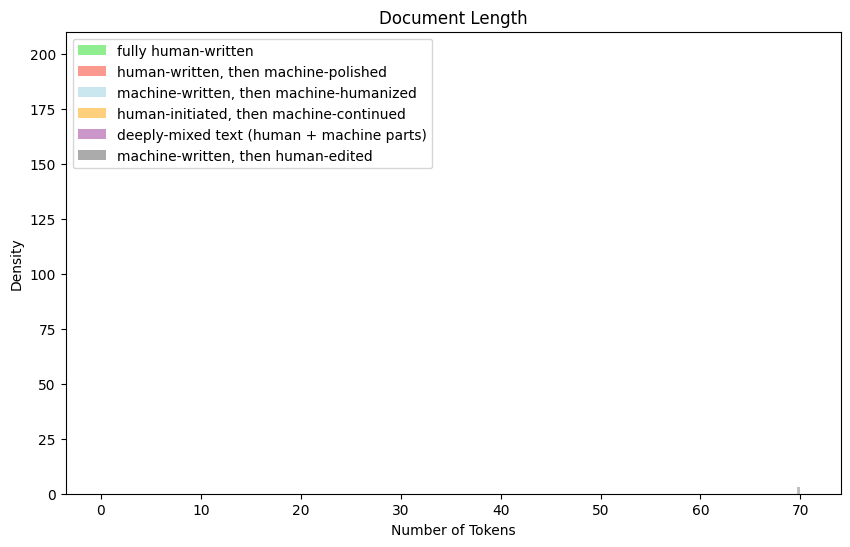

In [ ]:
classify_by_avg_doc_length(train_df, labels, cutoff=70)

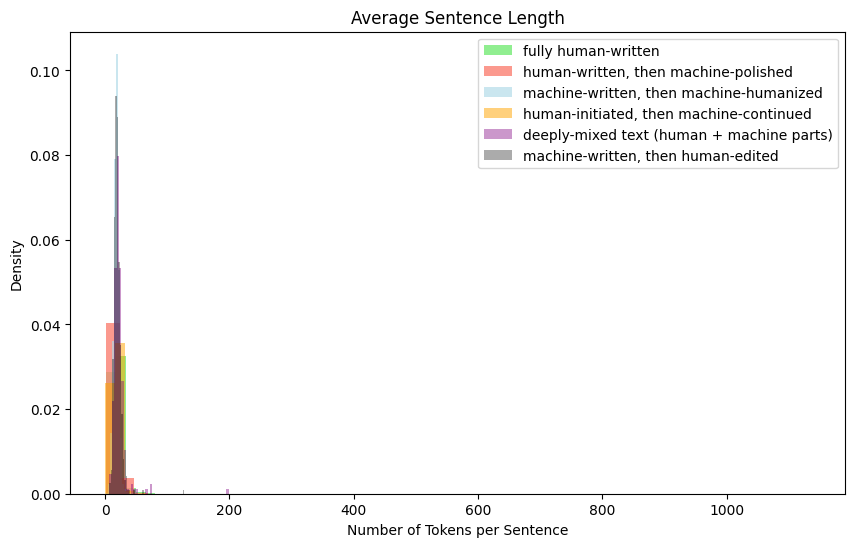

In [ ]:
classify_by_avg_sentence_length(val_df, labels)

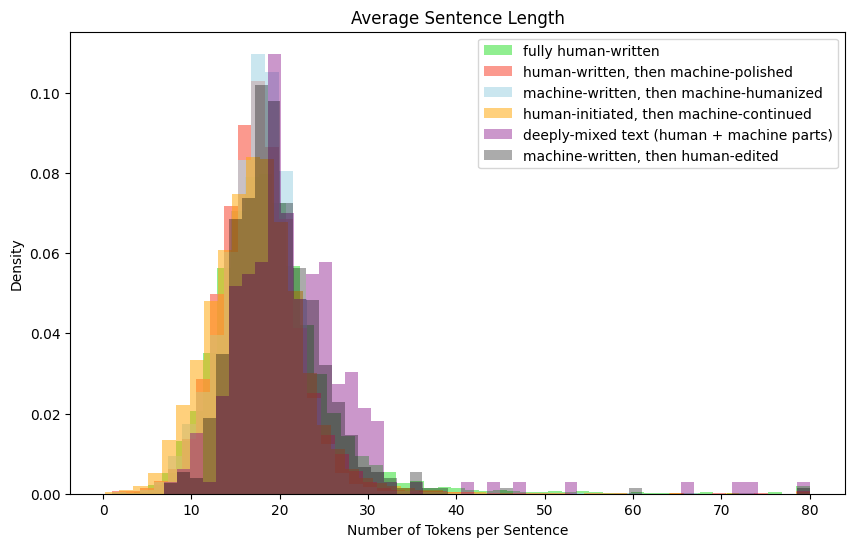

In [51]:
classify_by_avg_sentence_length(val_df, labels, cutoff=80)

## Average Word Length

The average word length seems to be significant, with AI usually generating longer tokens (words).

In [59]:
def classify_by_avg_word_length(dataframe, labels_mapping, cutoff=math.inf):
    avg_word_lengths = []
    for doc in dataframe.iter_rows():
        words = doc[0].split()
        avg_length = sum(len(word) for word in words) / len(words) if words else 0
        avg_word_lengths.append((min(avg_length, cutoff), labels_mapping[doc[2]]))  # -> (avg_length, label)
        
    lengths, labels_list = zip(*avg_word_lengths)

    plt.figure(figsize=(10, 6))
    for i in range(len(labels_mapping)):
        plt.hist([lengths[j] for j in range(len(lengths)) if labels_list[j] == labels_mapping[i]], 
                 bins=100, alpha=math.pow(0.8, i), label=labels_mapping[i], color=colors[i], density=True)
    plt.title(f'Average Word Length')
    plt.xlabel('Number of Characters per Word')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

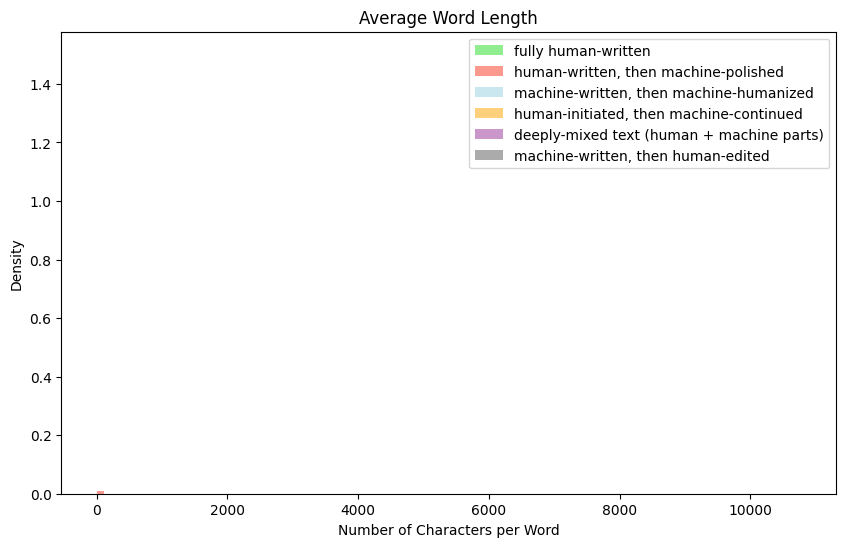

In [60]:
classify_by_avg_word_length(train_df, labels)

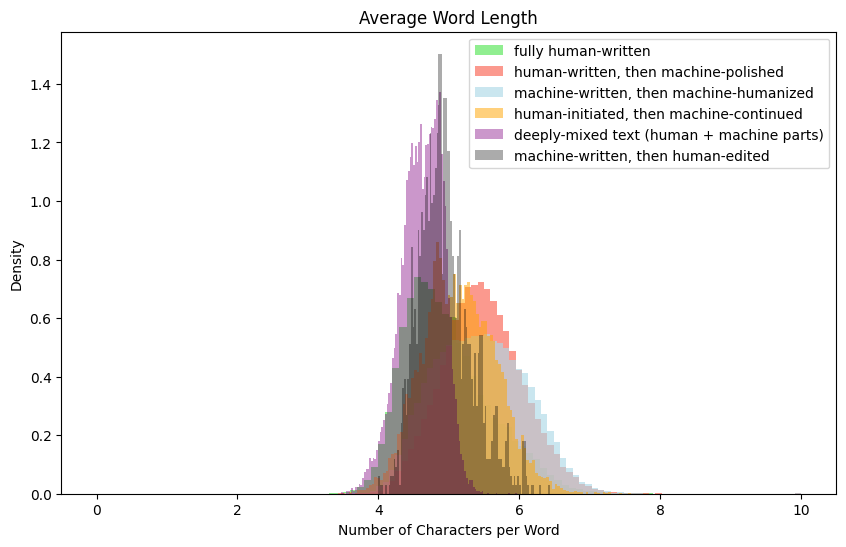

In [61]:
classify_by_avg_word_length(train_df, labels, cutoff=10)

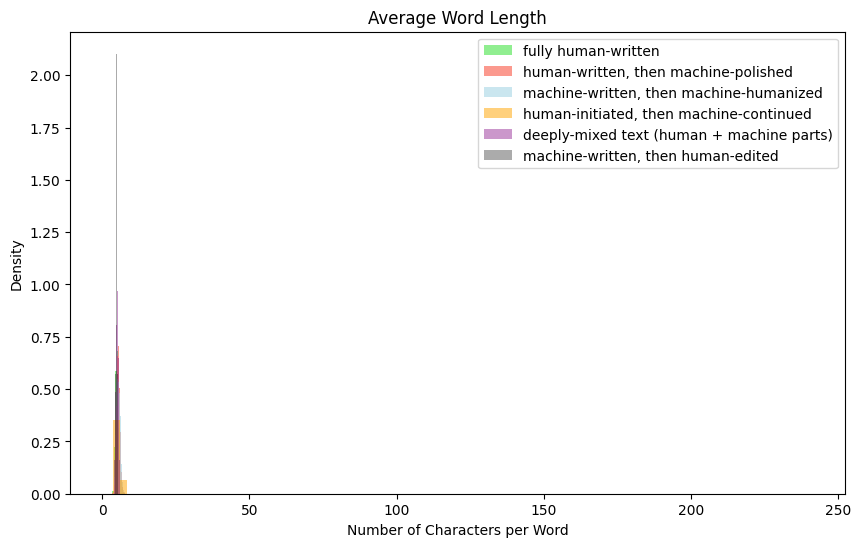

In [62]:
classify_by_avg_word_length(val_df, labels)

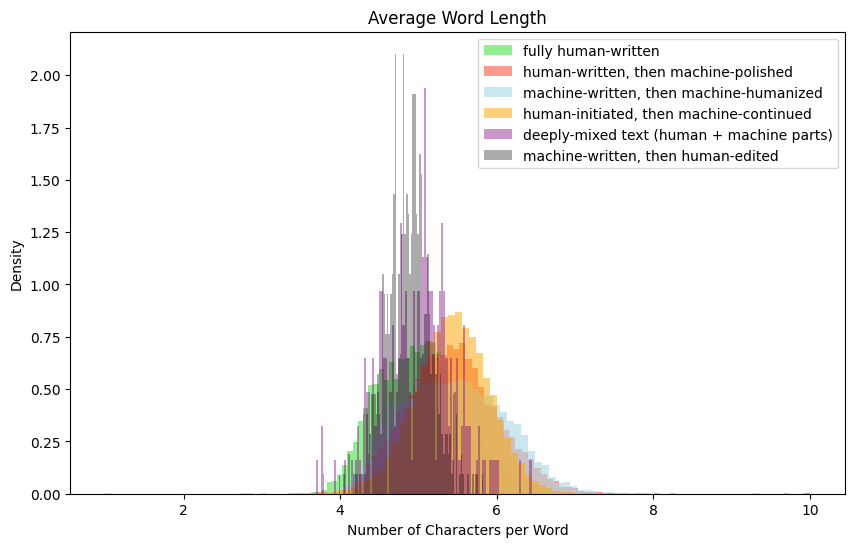

In [64]:
classify_by_avg_word_length(val_df, labels, cutoff=10)

## Type-Token Ratio (TTR)

Via TTR, we measure the lexical diversity in a text. We can calculate it as the ratio of unique words (i.e. types) to the total number of words (i.e. tokens) in a document. A higher TTR indicates higher lexical diversity, and lower TTR means that words are often repeated. Surprisingly, human-written texts seem to be less lexically diverse than AI-generated texts.

In [69]:
def classify_by_ttr(dataframe, labels_mapping):
    ttr_values = []
    for doc in dataframe.iter_rows():
        words = doc[0].split()
        unique_words = set(words)
        ttr = len(unique_words) / len(words) if words else 0
        ttr_values.append((ttr, labels_mapping[doc[2]]))  # -> (ttr, label)

    ttrs, labels_list = zip(*ttr_values)

    plt.figure(figsize=(10, 6))
    for i in range(len(labels_mapping)):
        plt.hist([ttrs[j] for j in range(len(ttrs)) if labels_list[j] == labels_mapping[i]], 
                 bins=100, alpha=math.pow(0.8, i), label=labels_mapping[i], color=colors[i], density=True)
    plt.title(f'Type-Token Ratio (TTR)')
    plt.xlabel('Type-Token Ratio (TTR)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

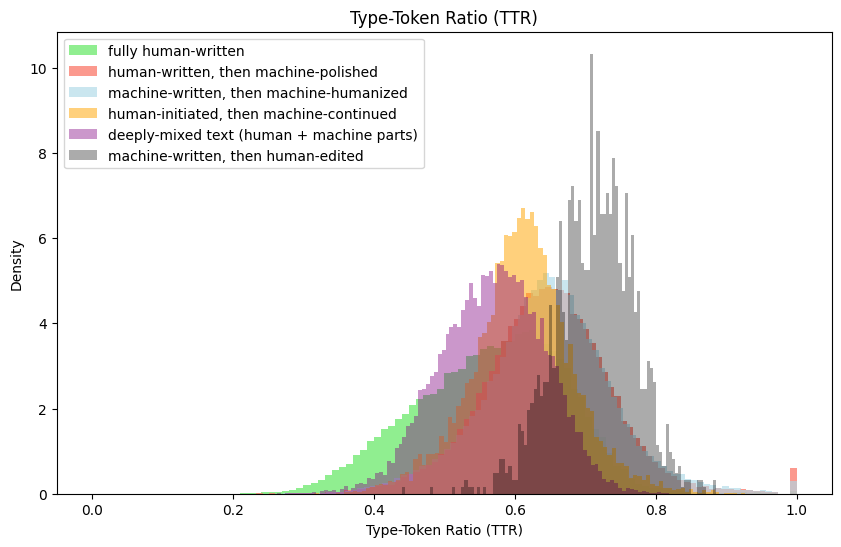

In [70]:
classify_by_ttr(train_df, labels)

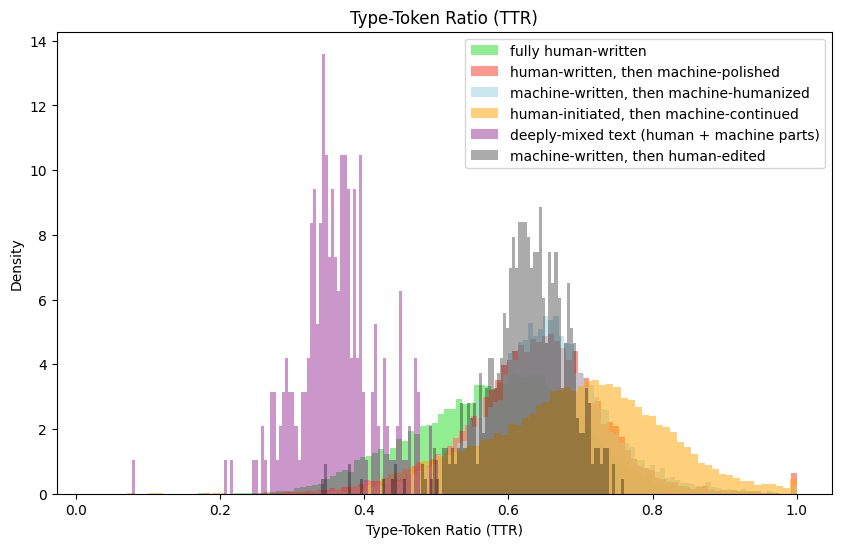

In [71]:
classify_by_ttr(val_df, labels)

## Stopword Ratio

As we can see, humans seem to use significantly more stopwords than AI models.

In [72]:
def classify_by_stopword_ratio(dataframe, labels_mapping):
    stop_words = set(stopwords.words('english'))
    stopword_ratios = []
    
    for doc in tqdm(dataframe.iter_rows(), total=len(dataframe)):
        words = word_tokenize(doc[0])
        stopword_count = sum(1 for word in words if word.lower() in stop_words)
        ratio = stopword_count / len(words) if len(words) > 0 else 0
        stopword_ratios.append((ratio, labels_mapping[doc[2]]))  # -> (ratio, label)

    ratios, labels_list = zip(*stopword_ratios)

    plt.figure(figsize=(10, 6))
    for i in range(len(labels_mapping)):
        plt.hist([ratios[j] for j in range(len(ratios)) if labels_list[j] == labels_mapping[i]], 
                 bins=100, alpha=math.pow(0.8, i), label=labels_mapping[i], color=colors[i], density=True)
    plt.title(f'Stopword Ratio')
    plt.xlabel('Stopword Ratio')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

100%|██████████| 288918/288918 [09:25<00:00, 511.24it/s]


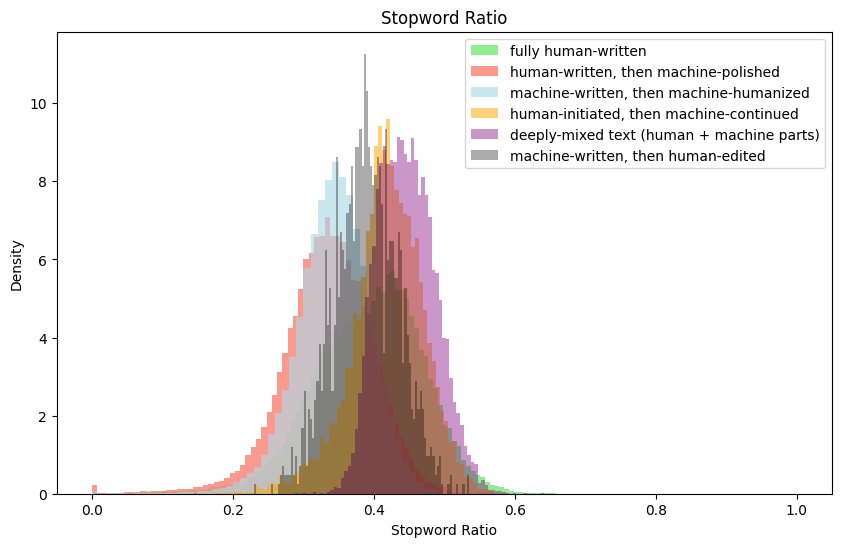

In [73]:
classify_by_stopword_ratio(train_df, labels)

100%|██████████| 72661/72661 [01:52<00:00, 644.55it/s]


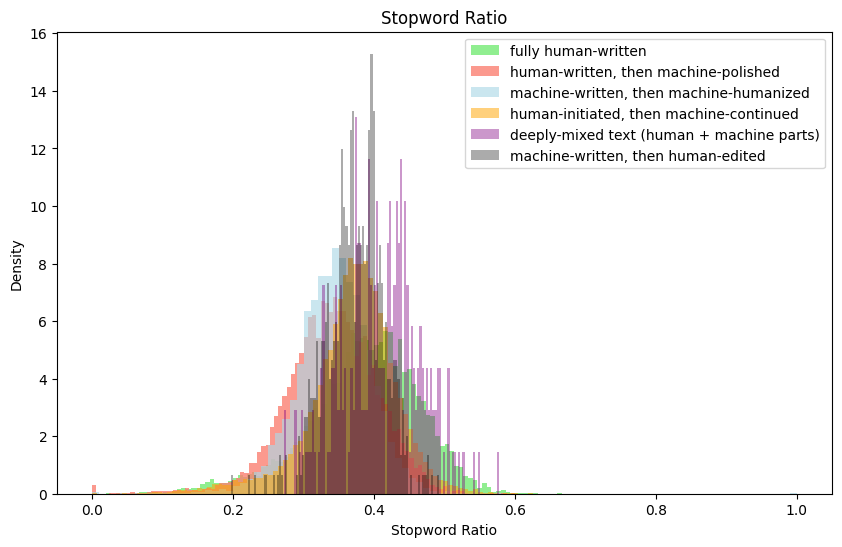

In [74]:
classify_by_stopword_ratio(val_df, labels)

## Punctuation Density

It seems like humans use more punctuations than AI models.

In [79]:
def classify_by_punctuation_density(dataframe, labels_mapping, cutoff=math.inf):
    punctuation_density = []
    for doc in tqdm(dataframe.iter_rows(), total=len(dataframe)):
        text = doc[0]
        punctuation_count = sum(1 for char in text if char in '.,;:!?')
        density = punctuation_count / len(text) if len(text) > 0 else 0
        punctuation_density.append((min(density, cutoff), labels_mapping[doc[2]]))  # -> (density, label)

    densities, labels_list = zip(*punctuation_density)

    plt.figure(figsize=(10, 6))
    for i in range(len(labels_mapping)):
        plt.hist([densities[j] for j in range(len(densities)) if labels_list[j] == labels_mapping[i]], 
                 bins=100, alpha=math.pow(0.8, i), label=labels_mapping[i], color=colors[i], density=True)
    plt.title(f'Punctuation Density')
    plt.xlabel('Punctuation Density')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

100%|██████████| 288918/288918 [00:16<00:00, 17802.51it/s]


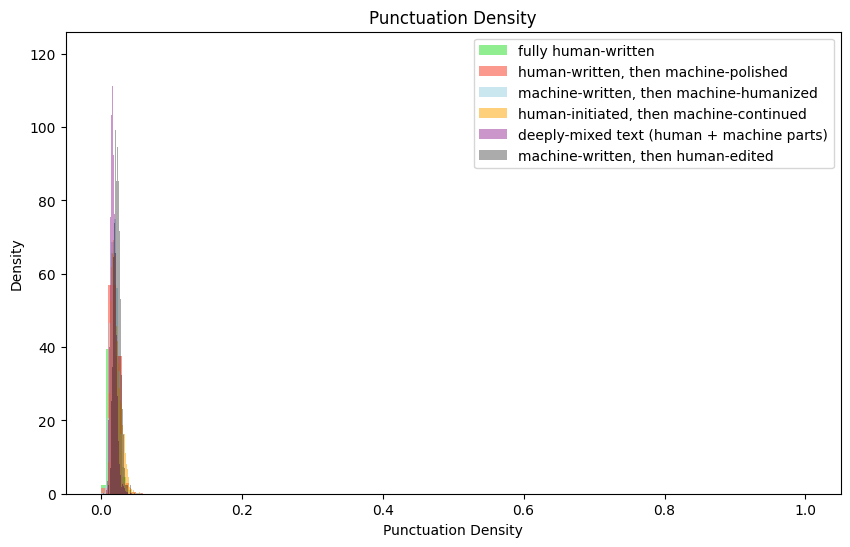

In [80]:
classify_by_punctuation_density(train_df, labels)

100%|██████████| 288918/288918 [00:16<00:00, 17577.20it/s]


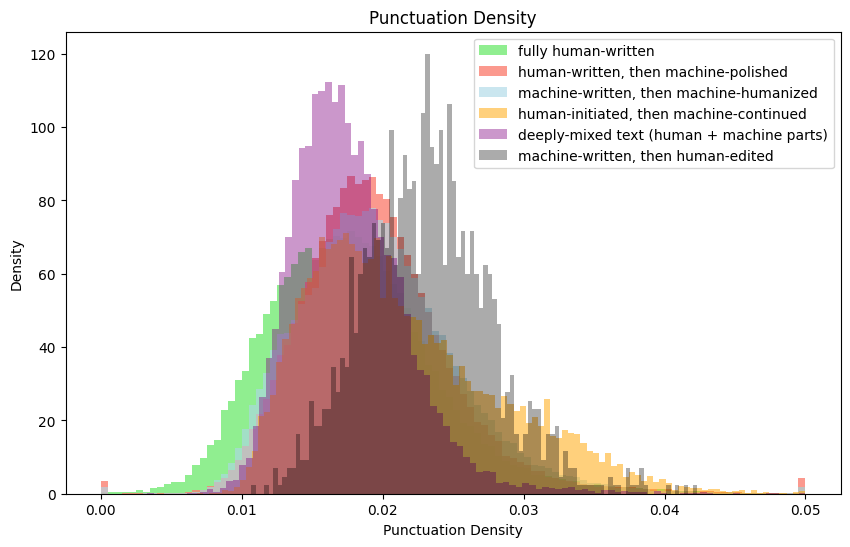

In [82]:
classify_by_punctuation_density(train_df, labels, cutoff=0.05)

100%|██████████| 72661/72661 [00:03<00:00, 21298.66it/s]


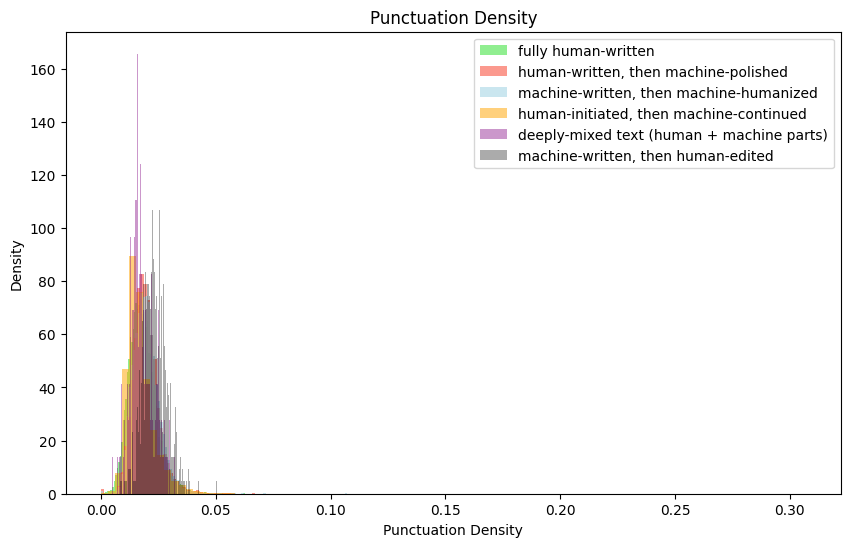

In [83]:
classify_by_punctuation_density(val_df, labels)

100%|██████████| 72661/72661 [00:03<00:00, 20727.51it/s]


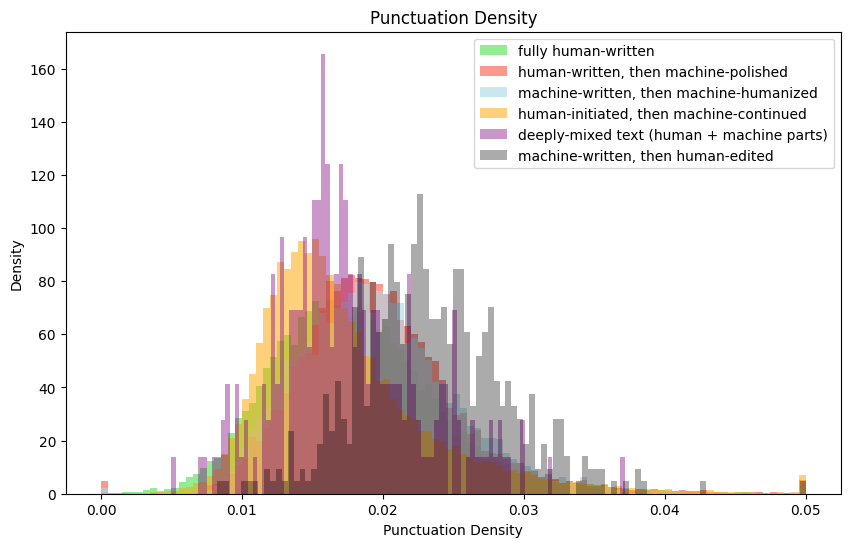

In [84]:
classify_by_punctuation_density(val_df, labels, cutoff=0.05)

## Inverse Document Frequency (IDF)

With IDF, we measure the informativeness or rarity of a word. A document high high IDF usually uses rare, specific or technical language, and vice versa. As we can see, LLM-generated text seems to use more rare words. This could also be connected to humans using more stopwords (=> very low IDF words), which we showed earlier.

In [85]:
def classify_by_idf(dataframe, labels_mapping):
    texts = [doc[0] for doc in dataframe.iter_rows()]
    labels_list = [labels_mapping[doc[2]] for doc in dataframe.iter_rows()]

    vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
    vectorizer.fit(texts)
    idf_values = vectorizer.idf_

    # avg idf per document
    avg_idf_per_doc = []
    for text in tqdm(texts):
        words = text.split()
        avg_idf = np.mean([idf_values[vectorizer.vocabulary_.get(word.lower(), 0)] for word in words if word.lower() in vectorizer.vocabulary_])
        avg_idf_per_doc.append(avg_idf)

    plt.figure(figsize=(10, 6))
    for i in range(len(labels_mapping)):
        plt.hist([avg_idf_per_doc[j] for j in range(len(avg_idf_per_doc)) if labels_list[j] == labels_mapping[i]], 
                 bins=100, alpha=math.pow(0.8, i), label=labels_mapping[i], color=colors[i], density=True)
    plt.title(f'Inverse Document Frequency (IDF)')
    plt.xlabel('Average IDF')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

 11%|█         | 32391/288918 [00:05<00:51, 4981.72it/s]/home/patrickstyll/Bachelorstudiengang-Software_and_Information_Engineering/8.Semester/AIR/steely/.venv/lib64/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/patrickstyll/Bachelorstudiengang-Software_and_Information_Engineering/8.Semester/AIR/steely/.venv/lib64/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 288918/288918 [01:07<00:00, 4304.15it/s]


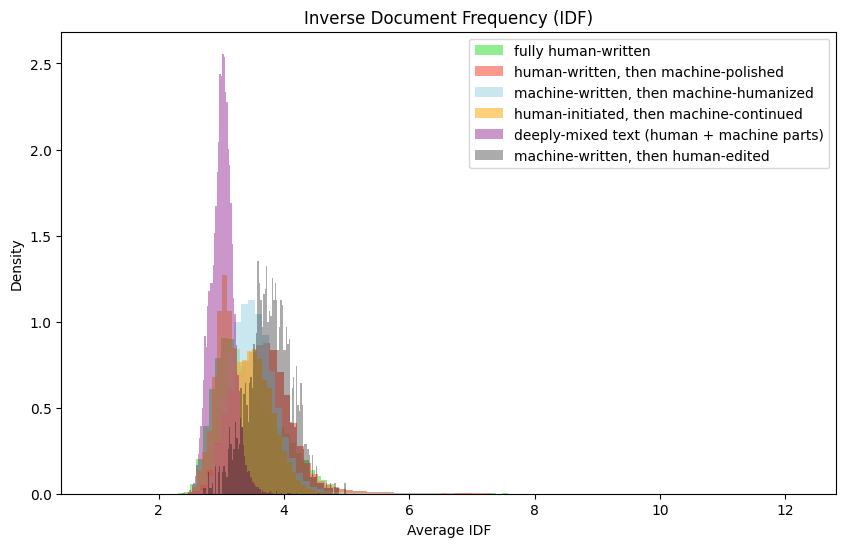

In [86]:
classify_by_idf(train_df, labels)

100%|██████████| 72661/72661 [00:12<00:00, 5596.15it/s]


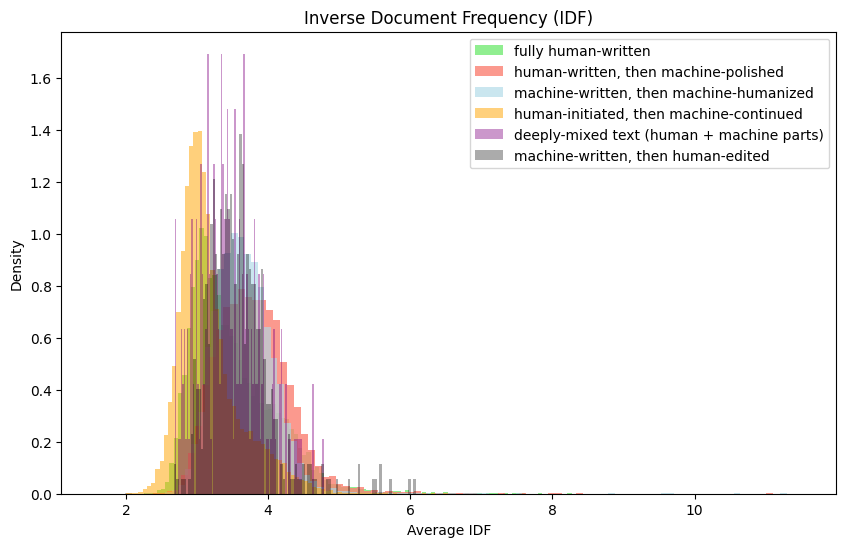

In [87]:
classify_by_idf(val_df, labels)

## Putting it all together...

Next, we put all such features into a dataframe and train a simple statistical model (i.e. Random Forest) on it.

In [88]:
def extract_features(dataframe):
    stop_words = set(stopwords.words('english'))
    
    vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
    vectorizer.fit([doc[1] for doc in dataframe.iter_rows()])
    idf_values = vectorizer.idf_

    features = []
    for doc in tqdm(dataframe.iter_rows(), total=len(dataframe)):
        text = doc[0]
        label = doc[2]

        # document length
        doc_length = len(text)

        # avg sentence length
        sentences = text.split('.')
        avg_sentence_length = sum(len(sentence.split()) for sentence in sentences if sentence.strip()) / len(sentences)

        # avg word length
        words = text.split()
        avg_word_length = sum(len(word) for word in words) / len(words) if words else 0

        # type-token ratio (TTR)
        unique_words = set(words)
        ttr = len(unique_words) / len(words) if words else 0

        # stopword ratio
        stopword_count = sum(1 for word in words if word.lower() in stop_words)
        stopword_ratio = stopword_count / len(words) if words else 0

        # punctuation density
        punctuation_count = sum(1 for char in text if char in '.,;:!?')
        punctuation_density = punctuation_count / len(text) if len(text) > 0 else 0
        
        # inverse document frequency (IDF)
        avg_idf = np.mean([idf_values[vectorizer.vocabulary_.get(word.lower(), 0)] for word in words if word.lower() in vectorizer.vocabulary_]) if words else 0

        features.append({
            'doc_length': doc_length,
            'avg_sentence_length': avg_sentence_length,
            'avg_word_length': avg_word_length,
            'ttr': ttr,
            'stopword_ratio': stopword_ratio,
            'punctuation_density': punctuation_density,
            'avg_idf': avg_idf,
            'label': label
        })

    return pl.DataFrame(features)

In [89]:
features_train = extract_features(train_df)
features_val = extract_features(val_df)
features_train.head()

100%|██████████| 72661/72661 [00:17<00:00, 4182.90it/s]


doc_length,avg_sentence_length,avg_word_length,ttr,stopword_ratio,punctuation_density,avg_idf,label
i64,f64,f64,f64,f64,f64,f64,i64
1005,15.384615,4.03,0.675,0.515,0.022886,NaN,4
1520,14.277778,5.311203,0.634855,0.452282,0.020395,NaN,3
1414,14.176471,4.86722,0.568465,0.485477,0.020509,NaN,4
1773,13.318182,5.037671,0.589041,0.445205,0.016356,NaN,4
1557,15.142857,3.899371,0.528302,0.556604,0.032755,NaN,4


In [90]:
X_train = features_train.drop('label').to_numpy()
y_train = features_train['label'].to_numpy()
X_val = features_val.drop('label').to_numpy()
y_val = features_val['label'].to_numpy()

In [91]:
rf_model = RandomForestClassifier(random_state=777,
                                  n_estimators=100,
                                  max_depth=None,
                                  max_features='sqrt',
                                  min_samples_split=10,
                                  min_samples_leaf=1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.29083001885468135

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.60      0.50     12330
           1       0.23      0.55      0.33     12289
           2       0.26      0.59      0.36     10137
           3       0.76      0.03      0.05     37170
           4       0.02      0.14      0.04       225
           5       0.00      0.00      0.00       510

    accuracy                           0.29     72661
   macro avg       0.28      0.32      0.21     72661
weighted avg       0.54      0.29      0.22     72661



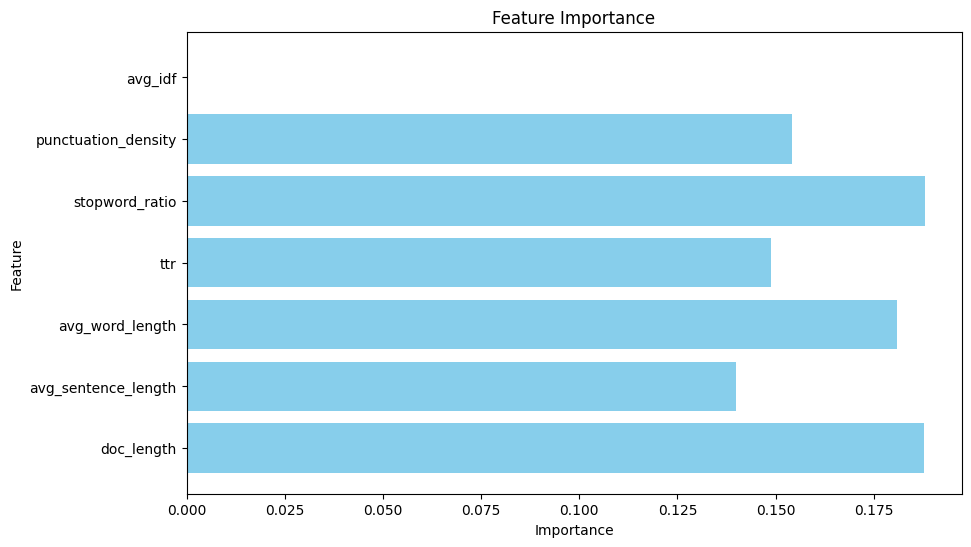

In [92]:
feature_names = features_train.columns[:-1]  # excl label
importances = rf_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()